In [1]:
from google.cloud import bigquery
bq = bigquery.Client()

In [2]:
%load_ext google.cloud.bigquery

In [3]:
%%bigquery
SELECT *
FROM cs320-f21.apr28.applications
LIMIT 5

Query is running:   0%|          |

Downloading:   0%|          |

,Timestamp,loan_amount,income,latitude,longitude
0,2023-04-18 15:47:56.141000+00:00,200000,75000,43.069610,-89.411429
1,2023-04-18 22:02:45.381000+00:00,500000,125000,43.044469,-89.432674
2,2023-04-19 14:24:42.341000+00:00,350000,80000,44.513755,-88.057333
3,2023-04-20 08:59:51.179000+00:00,190000,150000,43.889848,-91.197627
4,2023-04-25 22:12:49.061000+00:00,250000,25000,43.905450,-89.060410


# Geo Data

In [4]:
# 55 is WI
q = bq.query("""
SELECT county_geom
FROM bigquery-public-data.geo_us_boundaries.counties
WHERE state_fips_code = '55'
""")

In [5]:
df = q.to_geodataframe()

In [6]:
type(df)

geopandas.geodataframe.GeoDataFrame

<Axes: >

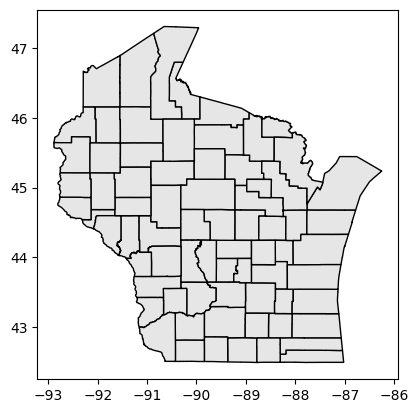

In [8]:
df.plot(edgecolor="k", facecolor="0.9")

# Export/Move Data

In [10]:
with open("export.geojson", "w") as f:
    f.write(df.to_json())

In [13]:
q = bq.query("""
CREATE OR REPLACE TABLE cs320-f21.apr28.wi
AS

SELECT county_name, county_geom
FROM bigquery-public-data.geo_us_boundaries.counties
WHERE state_fips_code = '55' -- is WI
""")

In [14]:
q.to_dataframe()

""


# Aggregates

In [15]:
q = bq.query("""
SELECT ST_UNION_AGG(county_geom)
FROM cs320-f21.apr28.wi
""")

In [16]:
wi = q.to_geodataframe()

<Axes: >

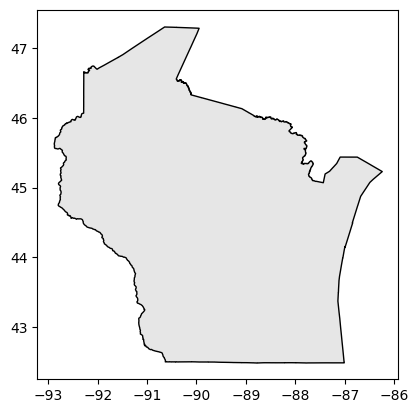

In [18]:
wi.plot(edgecolor="k", facecolor="0.9")

In [19]:
q = bq.query("""
SELECT ST_CENTROID(county_geom)
FROM cs320-f21.apr28.wi
""")
center_df = q.to_geodataframe()
center_df.head()

,f0_
0,POINT (-88.23079 43.36836)
1,POINT (-90.04145 44.45518)
2,POINT (-91.35853 44.30354)
3,POINT (-89.94822 43.42652)
4,POINT (-88.96488 44.47028)


<Axes: >

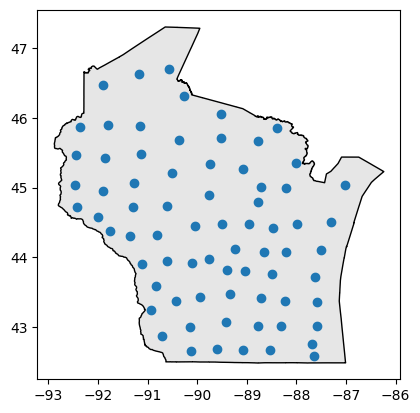

In [20]:
ax = wi.plot(edgecolor="k", facecolor="0.9")
center_df.plot(ax=ax)

In [21]:
q = bq.query("""
SELECT ST_CENTROID_AGG(county_geom)
FROM cs320-f21.apr28.wi
""")
center_df = q.to_geodataframe()
center_df.head()

,f0_
0,POINT (-89.70967 44.62668)


<Axes: >

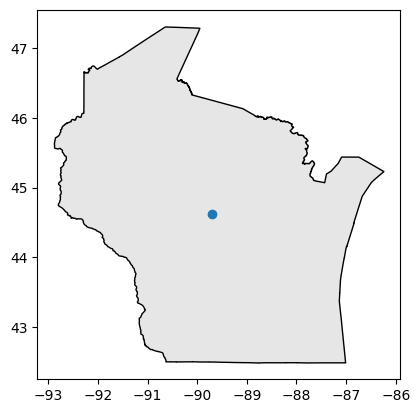

In [22]:
ax = wi.plot(edgecolor="k", facecolor="0.9")
center_df.plot(ax=ax)

# Create Houses with Geographic Column from form data

In [24]:
%%bigquery
CREATE OR REPLACE TABLE cs320-f21.apr28.houses

AS

SELECT *, ST_GEOGPOINT(longitude, latitude) AS loc
FROM cs320-f21.apr28.applications

Query is running:   0%|          |

""


In [27]:
q = bq.query("""
SELECT loc
FROM cs320-f21.apr28.houses
WHERE (latitude BETWEEN 40 and 60) AND (longitude BETWEEN -100 and -75)
""")
houses_df = q.to_geodataframe()
houses_df.head(3)

,loc
0,POINT (-89.40916 43.07346)
1,POINT (-89.43267 43.04447)
2,POINT (-89.40737 43.06982)


<Axes: >

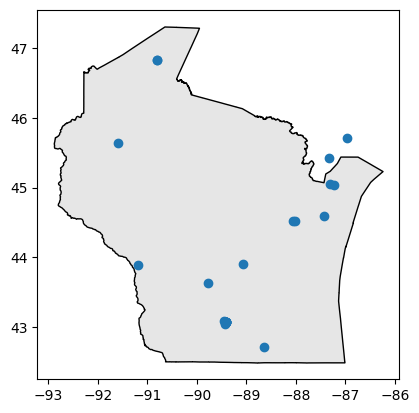

In [28]:
ax = wi.plot(edgecolor="k", facecolor="0.9")
houses_df.plot(ax=ax)

In [ ]:
# ST_WITHIN, ST_DWITHIN

In [29]:
q = bq.query("""
SELECT loc, county_name
FROM cs320-f21.apr28.houses, cs320-f21.apr28.wi
WHERE ST_WITHIN(houses.loc, wi.county_geom)
""")
houses_df = q.to_geodataframe()

<Axes: >

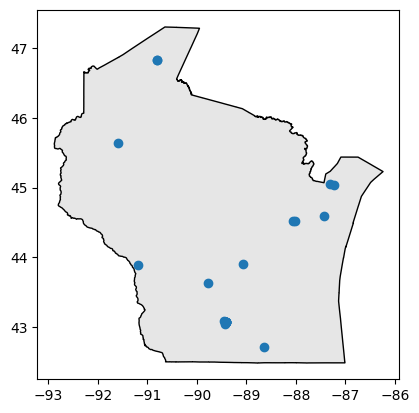

In [31]:
ax = wi.plot(edgecolor="k", facecolor="0.9")
houses_df.plot(ax=ax)

In [33]:
# sort houses by distance to the capitol

# ST_GEOGPOINT(-89.384107, 43.074715)

In [38]:
q = bq.query("""
SELECT *, ST_DISTANCE(houses.loc, ST_GEOGPOINT(-89.384107, 43.074715))/1000 AS km
FROM cs320-f21.apr28.houses
ORDER BY km ASC
LIMIT 10
""")
houses_df = q.to_geodataframe()
houses_df

,Timestamp,loan_amount,income,latitude,longitude,loc,km
0,2023-04-30 20:25:21.899000+00:00,200000,95000,43.073051,-89.401230,POINT (-89.40123 43.07305),1.403071
1,2023-04-30 13:04:10.189000+00:00,750000,200000,43.073051,-89.401230,POINT (-89.40123 43.07305),1.403071
2,2023-04-26 17:29:54.788000+00:00,10000000,10000000,43.072125,-89.403310,POINT (-89.40331 43.07212),1.586126
3,2023-04-30 22:57:40.311000+00:00,500000,200000,43.069820,-89.407370,POINT (-89.40737 43.06982),1.966420
4,2023-04-29 16:39:33.583000+00:00,20000000,2000000,43.073464,-89.409162,POINT (-89.40916 43.07346),2.039862
5,2023-04-18 15:47:56.141000+00:00,200000,75000,43.069610,-89.411429,POINT (-89.41143 43.06961),2.290741
6,2023-04-30 20:30:17.753000+00:00,523842,250000,43.076600,-89.412500,POINT (-89.41250 43.07660),2.315663
7,2023-04-18 22:02:45.381000+00:00,500000,125000,43.044469,-89.432674,POINT (-89.43267 43.04447),5.184624
8,2023-04-28 17:26:21.790000+00:00,220000,83000,43.084000,-89.450000,POINT (-89.45000 43.08400),5.450367
9,2023-04-30 22:27:09.823000+00:00,500000,200000,43.630617,-89.774278,POINT (-89.77428 43.63062),69.398199


In [36]:
# which houses are within a radius (10 km) of each county centroid?
q = bq.query("""
SELECT loc, county_name
FROM cs320-f21.apr28.houses, cs320-f21.apr28.wi
WHERE ST_DWITHIN(houses.loc, ST_CENTROID(wi.county_geom), 10000)
""")
houses_df = q.to_geodataframe()
houses_df

,loc,county_name
0,POINT (-89.40123 43.07305),Dane
1,POINT (-89.41250 43.07660),Dane
2,POINT (-89.40737 43.06982),Dane
3,POINT (-89.40123 43.07305),Dane
4,POINT (-89.41143 43.06961),Dane
5,POINT (-89.43267 43.04447),Dane
6,POINT (-89.45000 43.08400),Dane
7,POINT (-89.40916 43.07346),Dane
8,POINT (-89.40331 43.07212),Dane
9,POINT (-88.05733 44.51376),Brown


# Approximations

1. privacy
2. machine learning

In [39]:
# privacy
q = bq.query("""
SELECT ST_SNAPTOGRID(loc, 0.1)
FROM cs320-f21.apr28.houses
""")
q.to_geodataframe().head(5)

,f0_
0,POINT (-89.40000 43.10000)
1,POINT (99.10000 19.40000)
2,POINT (0.00000 0.00000)
3,POINT (-90.00000 -23.00000)
4,POINT (5.00000 34.00000)


In [42]:
# preprocessing for ML
q = bq.query("""
SELECT loc, ST_GEOHASH(loc, 4)
FROM cs320-f21.apr28.houses
""")
q.to_dataframe()

,loc,f0_
0,POINT(-89.4091622710936 43.0734635242975),dp8m
1,POINT(99.1332 19.4326),w5qq
2,POINT(0 0),7zzz
3,POINT(-90 -23),3gzv
4,POINT(5 34),sn59
5,POINT(89.4008 43.0722),tzxt
6,POINT(89.4008 43.0722),tzxt
7,POINT(45.5 43.9999),tpb6
8,POINT(40.7587 73.9787),uvhu
9,POINT(13 2),s235


# Machine Learning

In [43]:
import pandas as pd
import numpy as np
df = pd.DataFrame({"x1": np.random.randint(0, 10, 100).astype(float), 
                   "x2": np.random.randint(0, 3, 100).astype(float)})
df["y"] = df["x1"] + df["x2"] + np.random.rand(len(df))
df.head()

,x1,x2,y
0,0.0,0.0,0.075857
1,9.0,2.0,11.708795
2,8.0,0.0,8.167909
3,5.0,0.0,5.261211
4,2.0,0.0,2.137956


In [44]:
df.to_gbq("cs320-f21.apr28.tbl1")

100%|██████████| 1/1 [00:00<00:00, 3515.76it/s]


In [48]:
%%bigquery
CREATE OR REPLACE TABLE cs320-f21.apr28.traintest

AS

SELECT *, rand() < 0.25 AS test
FROM cs320-f21.apr28.tbl1

Query is running:   0%|          |

""


In [56]:
%%bigquery
CREATE OR REPLACE MODEL `cs320-f21.apr28.mymodel`
OPTIONS(model_type='LINEAR_REG', INPUT_LABEL_COLS=['y'])

AS

SELECT x1, x2, y
FROM `cs320-f21.apr28.traintest`
WHERE NOT test

Query is running:   0%|          |

""


In [58]:
%%bigquery
SELECT * FROM
ML.WEIGHTS(MODEL `cs320-f21.apr28.mymodel`)

Query is running:   0%|          |

Downloading:   0%|          |

,processed_input,weight,category_weights
0,x1,1.018184,[]
1,x2,1.085205,[]
2,__INTERCEPT__,0.304080,[]


In [63]:
%%bigquery
SELECT *
FROM
ML.PREDICT(
    MODEL `cs320-f21.apr28.mymodel`,
    (
        SELECT x1, x2, y
        FROM `cs320-f21.apr28.traintest`
        WHERE test
    )
)

Query is running:   0%|          |

Downloading:   0%|          |

,predicted_y,x1,x2,y
0,0.304080,0.0,0.0,0.673688
1,0.304080,0.0,0.0,0.088798
2,0.304080,0.0,0.0,0.953990
3,5.394999,5.0,0.0,5.261211
4,7.431367,7.0,0.0,7.052318
5,8.449551,8.0,0.0,8.281810
6,1.322264,1.0,0.0,1.153113
7,1.322264,1.0,0.0,1.286621
8,1.322264,1.0,0.0,1.504839
9,4.510857,2.0,2.0,4.168852


In [64]:
%%bigquery
SELECT 5 AS x1, 8 AS x2

Query is running:   0%|          |

Downloading:   0%|          |

,x1,x2
0,5,8


In [65]:
%%bigquery
SELECT *
FROM
ML.PREDICT(
    MODEL `cs320-f21.apr28.mymodel`,
    (
        SELECT 5 AS x1, 8 AS x2
    )
)

Query is running:   0%|          |

Downloading:   0%|          |

,predicted_y,x1,x2
0,14.076637,5,8


In [68]:
%%bigquery df
SELECT *
FROM
ML.EVALUATE(
    MODEL `cs320-f21.apr28.mymodel`,
    (
        SELECT x1, x2, y
        FROM `cs320-f21.apr28.traintest`
        WHERE test
    )
)

Query is running:   0%|          |

Downloading:   0%|          |

In [71]:
df.iloc[0].at["r2_score"]

0.9939446505650471